<H1> Random forest-based variable importance measure </H1>

Materials for the lecture on "Random forest-based variable importance measure", ECAS-SFdS 2023 School on "Random Forests: basics, extensions, and applications".

__Author__: Pierre Geurts, p.geurts@uliege.be

<B> Introduction </B><BR>

For this practical, we will use the machine learning library [`Scikit-learn`](https://scikit-learn.org/stable/), which is one of the most popular machine learning toolboxes. It contains in particular implementations of various tree-based methods, including standard classification and regression trees, random forests, and various variants of boosting. With respect to R, the implementation in Scikit-learn of tree-based method lacks the direct support for categorical variables (that need to be encoded into numerical variables) and for missing values (that needs to be replaced before model training). The library does not offer either the regular MDA OOB-based importance score, only the model-agnostic version based on an independent test set. The OOB MDA is however available in the [`rfpimp`](https://pypi.org/project/rfpimp/) library. Below, we use also the shap module that implements Shapley values additive explanations. Some specific functions are also made available to you in the `ECAS.py` companion file.

The practical is provided as a jupyter notebook. You can either run in two ways:
1. locally on your computer (assuming you have a full installation of python. See the front page of the github for instructions). In this latter case, you need to download the ECAS.py file in the same directory as the notebook and then run jupyter lab to open the notebook.
2. on google colab. In this case, you will need to uncomment some installation instructions at the beginning of the notebook.

The notebook is organized into the following sections (following the lecture):
* Setup
* Global importances
* Local importances
* Variable selection

You can see the table of content to the left to navigate through the document but to run a particular section, you have first to run fully the setup section that loads the data and import the required libraries.


# Setup

Installation of the required packages and global imports.


In [ ]:
# uncomment and execute the next lines if you are on google colab to install
# the required packages and download the needed files.

# !pip install matplotlib numpy pandas scikit-learn rfpimp shap
# !wget https://raw.githubusercontent.com/tuxette/ecas23_randomforest/main/pierre/vimp/ECAS.py
# !wget https://raw.githubusercontent.com/tuxette/ecas23_randomforest/main/pierre/vimp/data/winequality-red.csv
# !mkdir data
# !mv winequality-red.csv data/
# This last package can also be installed with pip but it is then bugged
# !wget https://raw.githubusercontent.com/scikit-learn-contrib/boruta_py/master/boruta/boruta_py.py

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import rfpimp
import shap
from sklearn.metrics import mean_squared_error
from ECAS import *

RS = 12345 # random seed used throughout the notebook
# uncomment this line if you want to generate larger plots.
#plt.rcParams["figure.figsize"] = (11, 7)

## Load data

The dataset used throughout this session comes from the following reference:
* _P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
            "Modeling wine preferences by data mining from physicochemical properties".
            In Decision Support Systems, Elsevier, 47(4):547-553, 2009._
and can be found here: http://www3.dsi.uminho.pt/pcortez/wine/winequality.zip

The inspiration to use this dataset comes from the following __[tutorial](https://github.com/glouppe/talk-pydata2015)__.

It contains 11 features describing 1599 red wines. The target to be predicted is the preference given to the wine (a integer between 3 and 9).

_As an exercice, you can alternatively run the practical on another dataset, for example on a classification problem. A dataset is suggested in the comment of the next block of code. You would have to change in the code every parts that refer to regression trees or forests._


Let us load the data.

In [ ]:
# Load data

# wine preference regression problem:
wines = pd.read_csv("data/winequality-red.csv", sep=";")
target = "quality"
feature_names = wines.columns.drop(target).values
indices = np.random.default_rng(seed=RS).permutation(len(wines))
X = wines.drop(target, axis=1)
y = wines[target]

# Uncomment the next four lines to use an alternative classification problem:

#from sklearn.datasets import fetch_openml
#X, y = fetch_openml(
#    data_id=45017, as_frame=True, return_X_y=True, parser="pandas"
#)
# feature_names = X.columns.values

X

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2


Divide the data into a train (75%) and test sets (25%).

PS: you will see the parameter `random_state` in a lot of command below. This is not necessary but it ensures that the results will remain the same everytime you rerun the notebook.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RS)

# Global importances

## Single regression tree

We will fist fit a single regression tree and look at the MDI importances. This part will also serve as an introduction to the main features of scikit-learn.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
rt = DecisionTreeRegressor(random_state=RS)
# show the model hyper-parameters (work for any model)
rt.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 12345,
 'splitter': 'best'}

You can get an explanation of these hyper-parameters by using `help(DecisionTreeRegressor)`. Try to understand what they all mean.

In scikit-learn, a given model is trained with the `fit` method. A prediction is thenobtained with the `predict` (or `predict_proba` to get class probability predictions in classification) method.


In [ ]:
# Train the tree with default parameters on the training set
rt.fit(X_train, y_train)
# Predict the output for the first test instances:
rt.predict(X_test)[0]

6.0

Test the mean squared error of the tree on the train and test set:

In [ ]:
# Test the tree
mse_train = mean_squared_error(y_train, rt.predict(X_train))
mse_test  = mean_squared_error(y_test, rt.predict(X_test))
print("DT Training MSE: ", mse_train, "- Test MSE: ", mse_test)

DT Training MSE:  0.0 - Test MSE:  0.6675


The tree clearly overfits the data, because by default no pruning is carried out. Let's look at the tree:

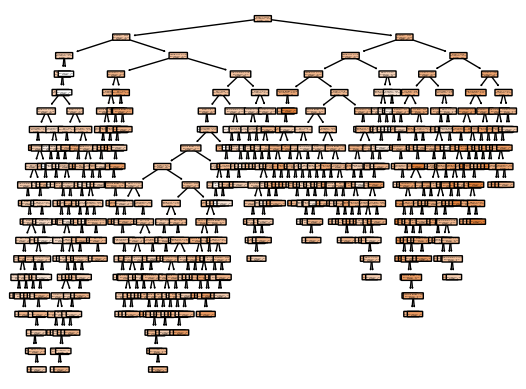

In [ ]:
# Look at the tree (can be long)
tree.plot_tree(rt, feature_names=rt.feature_names_in_, filled=True, rounded=True)
plt.show()

Let us look at the MDI importances computed from this tree. In all tree-based models in scikit-learn, these importances are computed during training and directly available in the `feature_importances_` field of the class (in scikit-learn, the field names ending by `_` indicate outputs of training). We provide a fonction `plot_importances` in ECAS.py to show these importances. Changing the argument order from True to False avoid sorting the importances, which might ease comparisons between rankings.

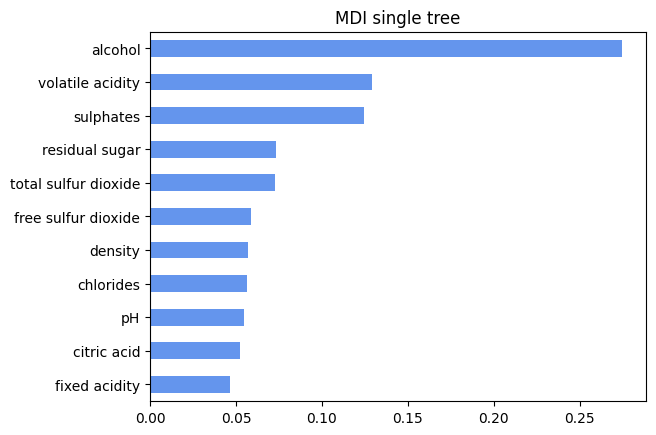

In [ ]:
plot_importances(rt.feature_importances_, feature_names, title="MDI single tree", order=True)

Feature importances are normalized by their sum so that they represent the fraction of the variance explained by the tree due to this variable (in regression). Note that in scikit-learn, these importances do not take into account suggorate splits (see Robin's practicals).

*__Suggested experiments:__*
_Change the regression tree hyper-parameters (in particular set max_depth to 1 and then 5) and look at how this affect MDI importances. Parameters of a method can be set to a different value with `rt.set_params(max_depth=1)` or by changing the initial definition of the model `rt=RegressionTree(max_depth=1)`_.

## Random Forests

Now let's build a random forest. The parameter oob_score is set to True to compute OOB scores.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(oob_score = True, n_estimators=1000, random_state=RS)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': True,
 'random_state': 12345,
 'verbose': 0,
 'warm_start': False}

Try to understand the meaning of these parameters (you can get an explanation using `help(RandomForestRegressor)`). The main ones are `max_features` (the number/proportion of features selected at each node, often called $mtry$ in other implementations) and `n_estimators` (the number of trees). `oob_score`set to `True` means that the OOB score is computed (by default in regression, the score is $R^2$).

_What is the default setting for `mtry` and how large are the trees by default?_
> In regression, the default value of max_features is 1.0, meaning that the default forests are equivalent to bagging. By default, the trees are also unpruned.

Let us train the forest and test it:

In [ ]:
# train the model (use verbose = 2 to see progression)
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=12345)

In [ ]:
# test it
mse_train = mean_squared_error(y_train, rf.predict(X_train))
mse_oob = (1-rf.oob_score_)*np.var(y_train)
mse_test = mean_squared_error(y_test, rf.predict(X_test))
print("RF Training MSE: ", mse_train, "- OOB MSE: ", mse_oob, "- Test MSE: ", mse_test)

RF Training MSE:  0.047184600500417014 - OOB MSE:  0.3492724261766204 - Test MSE:  0.3207244


The OOB score matches the test set score very well. Compare this score with the one of single regression tree.

Now, let us plot the MDI importances:

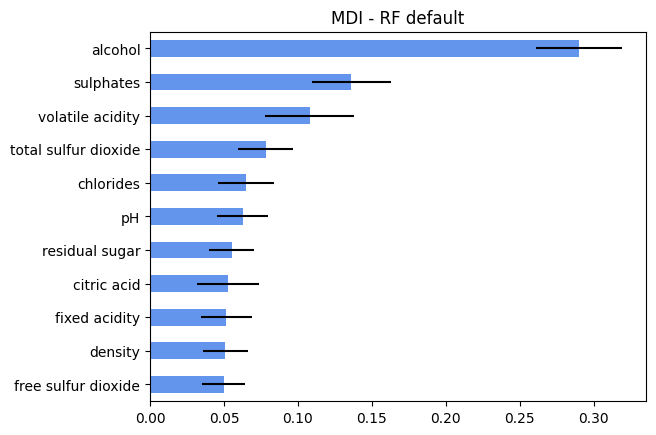

In [ ]:
std_mdi_default = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
mdi_default = rf.feature_importances_
plot_importances(mdi_default, feature_names, title="MDI - RF default", stderr=std_mdi_default, order=True)

Compare this plot with the one obtained with a single tree. You should observe some modification in the ranking. Which one do you trust the most?

Let us now optimise `max_features` by using the OOB score.

In [ ]:
oob_scores_mf = []
rf = RandomForestRegressor(oob_score=True, n_estimators=500, random_state=RS)
for m in range(1, X.shape[1]+1):
    print('.',end='') # to show the progress
    rf.set_params(max_features = m)
    rf.fit(X_train,y_train)
    oob_scores_mf.append(rf.oob_score_)
print('Done')

...........Done


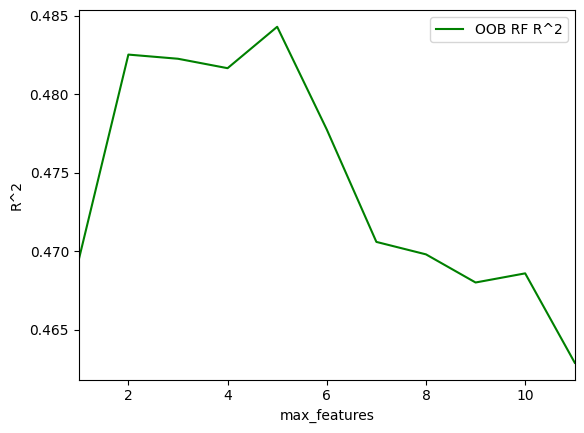

In [ ]:
# plot the curve
plt.errorbar(range(1, X.shape[1]+1),oob_scores_mf,label="OOB RF R^2", color="g")
plt.xlabel('max_features')
plt.xlim(1, X.shape[1])
plt.ylabel("R^2")
plt.legend(loc="best")
plt.show()

To automatise further this step, one could have used as well scikit-learn's GridSearchCV method, in the code below using oob score estimation to do that:

Best params found:  {'max_features': 5}


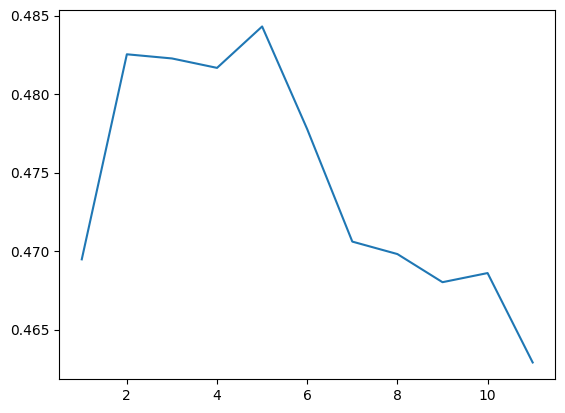

In [ ]:
# alternative version using scikit-learn:
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor(oob_score=True, n_estimators=500, random_state=RS)
cv = GridSearchCV(
    rf,
    {"max_features": range(1,X_train.shape[1]+1)},
    cv=[(np.arange(X_train.shape[0]), np.empty(0, dtype=int))],
    scoring=lambda est, X, y: est.oob_score_,
)
results = cv.fit(X_train, y_train)
plt.plot(range(1,X_train.shape[1]+1),results.cv_results_['mean_test_score'])
len(results.cv_results_['mean_test_score'])
print("Best params found: ", cv.best_params_)

The curve is exactly the same as we fixed the random_state parameter. _You can try to change it for another value (replace RS by another integer number) to see how (un)stable the results are._

Let us retrain a new forest with more trees with a value of mtry equal to 3:

In [ ]:
# Set mtry to its optimum and rerun with more trees
rf.set_params(max_features=5, n_estimators=1000, oob_score=True, random_state=RS)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=5, n_estimators=1000, oob_score=True,
                      random_state=12345)

In [ ]:
# test it
mse_train = mean_squared_error(y_train, rf.predict(X_train))
mse_oob = (1-rf.oob_score_)*np.var(y_train)
mse_test = mean_squared_error(y_test, rf.predict(X_test))
print("RF Training MSE: ", mse_train, "- OOB MSE: ", mse_oob, "- Test MSE: ", mse_test)

RF Training MSE:  0.045669829858215175 - OOB MSE:  0.33767953819548086 - Test MSE:  0.322416845


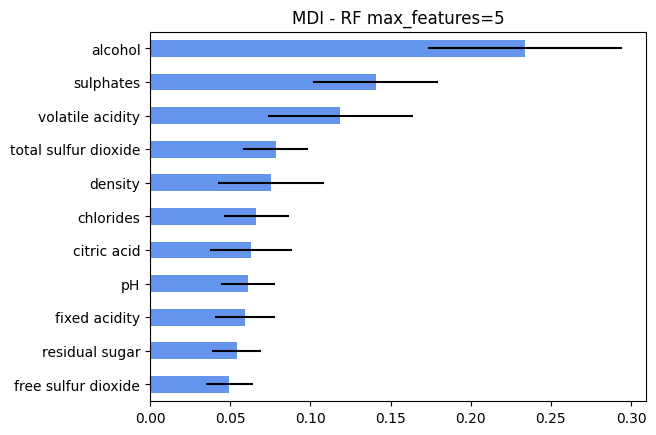

In [ ]:
mdi_mtry_5 = rf.feature_importances_
std_mtry_5 = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
plot_importances(mdi_mtry_5, feature_names,
                 title="MDI - RF max_features="+str(rf.max_features),
                 order=True, stderr=std_mtry_5
)

Let us plot the importances with the default setting and the one with mtry=3 on the same plot to compare them:

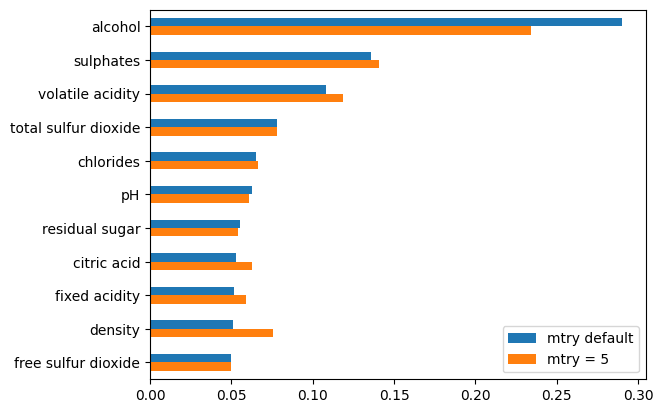

In [ ]:
# you can put both importances on the same plot with this command:
plot_importances_comp([mdi_default, mdi_mtry_5], ['mtry default','mtry = 5'],
                      feature_names=feature_names, order=True)

Compare and explain the differences between the two sets of importance scores.

> _Previously max_features was set to 1.0, which made RF equivalent to bagging. Decreasing mtry gives more chance to less relevant variables to be selected and thus the difference between the less important and the more important variables is reduced._

Let us now compute MDA importances with OOB error using the rfpimp library.

In [ ]:
import rfpimp
I = rfpimp.oob_importances(rf, X_train, y_train)
# We put it in the same format as the other importances
mda_oob_mtry_5 = I.reindex(feature_names).to_numpy().ravel()
mda_oob_mtry_5 = mda_oob_mtry_5/np.sum(mda_oob_mtry_5)

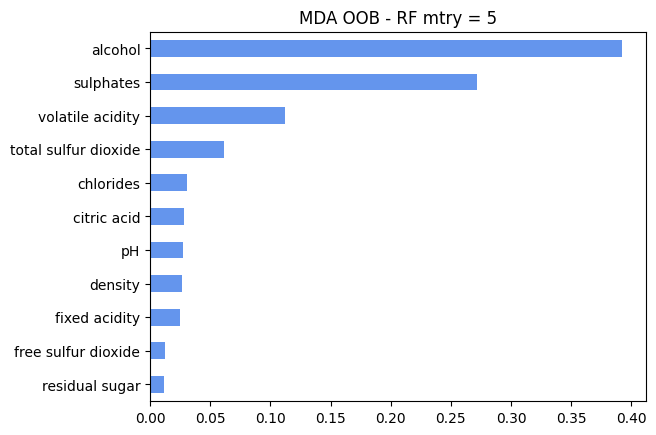

In [ ]:
plot_importances(mda_oob_mtry_5,
    feature_names, title="MDA OOB - RF mtry = 5",
    order=True
)

Let us compare these importances with the MDI ones for the same mtry value:

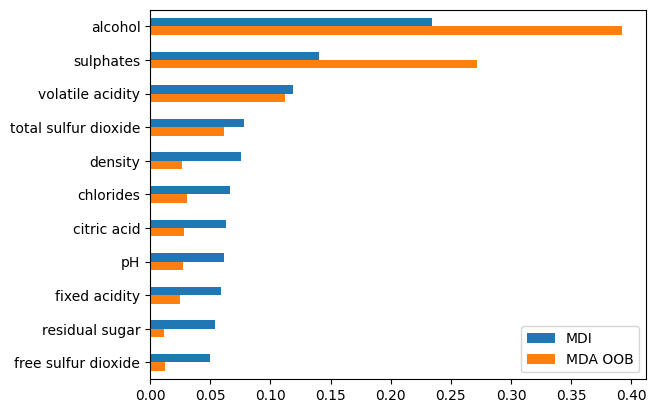

In [ ]:
plot_importances_comp([mdi_mtry_5,mda_oob_mtry_5],['MDI','MDA OOB'],
                      feature_names=feature_names, order=True)

What are the main differences between the two importances?

> rfpimp does not allow to fix the random_state, so that your results might differ from one run to the next. What you will observe is that the ranking of the top variables will be the same for both importance measures but difference will start to appear at the bottom. MDI also typically procudes importances that are more uniform among variables than MDA. There are also some strong differences in importance for some variables. We will discuss a case below.

A third way to compute feature importance in scikit-learn is to use an independent test set instead of the OOB error. This is done with the `permutation_importance` function. The advantage of this function is that it works for any models. This method repeats the permutations several times, which allows to get standard error for the importances:

In [ ]:
from sklearn.inspection import permutation_importance
IMDAsk = permutation_importance(rf, X_test, y_test, n_repeats=20, random_state=RS)
mda_ts_mtry_5 = IMDAsk['importances_mean']/np.sum(IMDAsk['importances_mean'])

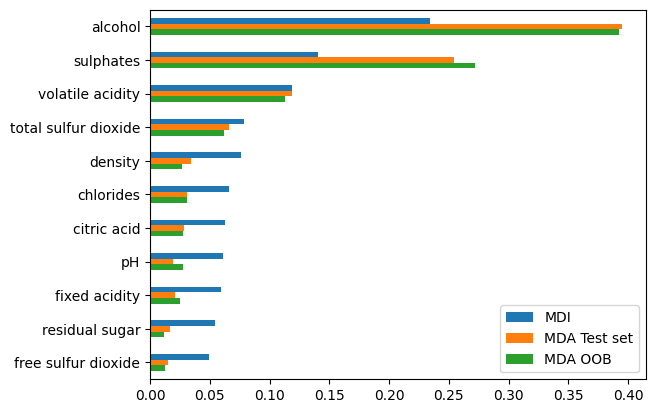

In [ ]:
plot_importances_comp([mdi_mtry_5, mda_ts_mtry_5, mda_oob_mtry_5],["MDI","MDA Test set","MDA OOB"],
                      order = True, feature_names=feature_names
)

Compare the three different importances obtained so far (MDI, MDA OOB and MDA test set). Are the features ranked similarly?

> MDA OOB and MDA test set are very close as expected. MDI gives more importance to the less important variables relatively. The ranking is a bit different. A notable difference is that MDI ranks `density` much higher than MDA.

One knows that MDI is biased towards variables of high cardinality and that there are problems with both measures in case of high correlations between the features. Let us inspect if this problem is present on this dataset.

The following command counts the number of different values for each feature in the dataset:

In [ ]:
X_train.nunique()

fixed acidity            90
volatile acidity        136
citric acid              76
residual sugar           82
chlorides               135
free sulfur dioxide      58
total sulfur dioxide    141
density                 388
pH                       87
sulphates                89
alcohol                  59
dtype: int64

`density` is the variable with the greatest number of unique values. This might explain why it gets so highly ranked by MDI which is known to be biased towards such variable.

As a correction, [Zhou and Hooker (2021)](https://dl.acm.org/doi/abs/10.1145/3429445) proposed to restimate MDI using OOB samples. This is done by the functions `debias_mdi_clas` and `debias_mdi_regr` in the ECAS.py file (the implementation comes from [Zhou's github](https://github.com/ZhengzeZhou/unbiased-feature-importance/tree/master)). Let's try it:

In [ ]:
unbiased_mdi = debiased_mdi_regr(rf, X_train.values, y_train.values)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

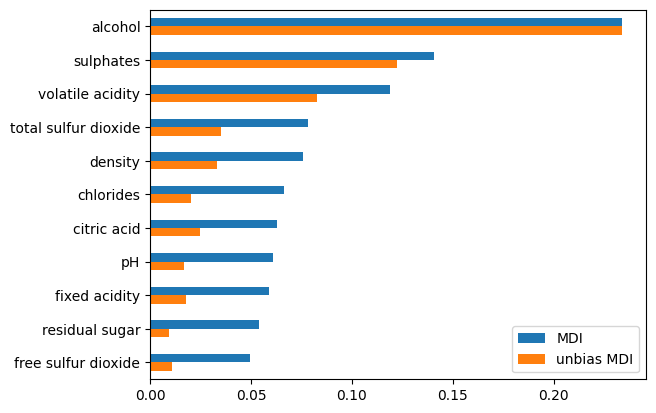

In [ ]:
plot_importances_comp([mdi_mtry_5, unbiased_mdi], feature_names=feature_names,
                 title=["MDI","unbias MDI"],
                 order=True
)

This indeed decreases the relative importance of `density` and make the importances closer to the ones obtained by MDA, although there nevertheless remain differences between unbiased MDI and MDA.

Another source of problems is high correlation between features. `rfpimp` offers several tools to check for the presence of highly correlated pairs of features, e.g.:

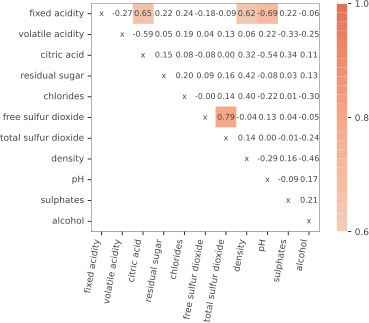

In [ ]:
# control of the correlation between the features
rfpimp.plot_corr_heatmap(X_train)

The highest correlation is between `total sufur dioxide` and `free sulfur dioxide`. In the case of MDI, this means that `free sulfur dioxide` might capture some information that will make `total sulfur dioxide` less important than it is. In the case of MDA, randomly permuting each of these features might create examples that are far from the initial distribution, which has an effect difficult to predict.

*__Suggested experiments__*: _repeat the whole experiment while removing `free sulfur dioxide` to see if it affects the rankings of MDA and MDI. The code below creates new train and test sets without this feature and plot the unbiased MDI. Adapt it to plot MDA OOB._

In [ ]:
X_train_red = X_train.drop(['free sulfur dioxide'], axis=1)
X_test_red = X_test.drop(['free sulfur dioxide'], axis=1)
feature_names_red = X_train_red.columns.values
rfred = RandomForestRegressor(n_estimators=1000, max_features=5, oob_score = True, random_state=RS)
rfred.fit(X_train_red, y_train)
mse_train = mean_squared_error(y_train, rfred.predict(X_train_red))
mse_oob = (1-rf.oob_score_)*np.var(y_train)
mse_test = mean_squared_error(y_test, rfred.predict(X_test_red))
print("RF Training MSE: ", mse_train, "- OOB MSE: ", mse_oob, "- Test MSE: ", mse_test)

RF Training MSE:  0.04631651042535446 - OOB MSE:  0.33767953819548086 - Test MSE:  0.321907025


MSE is mostly unaffected.

In [ ]:
unbiased_mdi_red = debiased_mdi_regr(rfred, X_train_red.values, y_train.values)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

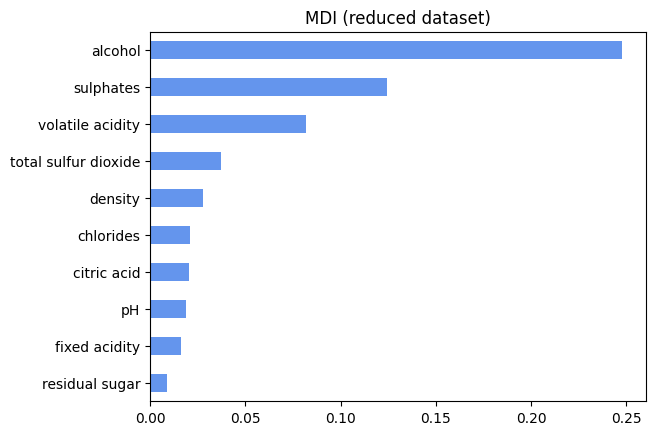

In [ ]:
plot_importances(unbiased_mdi_red, feature_names_red,
                 title="MDI (reduced dataset)",
                 order=True
                )

Removing `free sulfur dioxide` makes `total sulfur dioxide` a bit more important according to debiased MDI. What about MDA OOB?

> _The ranking is also mostly unaffected, meaning that this correlation is not hurtful_

*__Suggested experiment:__* _Try to add a copy of the alcohol variable, with some additive independent gaussian noise, and look at the effect on the MDI/MDA plots. The code in the box below create a new dataset with such feature_

> _The effect that you should observe is that the importance of `alcohol` for both measures will decrease. At some point, it will make `alcohol` less important than `sulphates` and/or `volatile acidity`. This is the expected behaviour with MDI. With MDA, correlation might sometimes actually increases the importance of the correlated features (see the lecture for an example)._

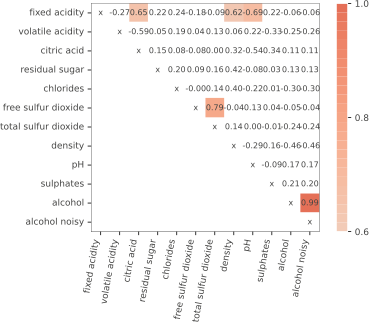

In [ ]:
X_train_corr = X_train.copy()
X_test_corr = X_test.copy()
X_train_corr['alcohol noisy'] = X_train_corr['alcohol']+0.1*np.random.normal(size=X_train.shape[0])
X_test_corr['alcohol noisy'] = X_test_corr['alcohol']+0.1*np.random.normal(size=X_test.shape[0])
rfpimp.plot_corr_heatmap(X_train_corr)

# Local importances with SHAP

In this second part, we will experiment with local variable importances as computer by [SHAP](https://github.com/shap/shap) (shapley additive explanation). Let us retrain a clean RF model on the original data. The shap method being slow, we will reduce the forest to 500 trees.

In [ ]:
rf = RandomForestRegressor(max_features = 5, n_estimators=500, oob_score=True, random_state=RS)
rf.fit(X_train, y_train)
(1-rf.oob_score_)*np.var(y_train) # just a check of the OOB MSE

0.3375171456343134

The following code defines an explainer for our RF model. One could use Explainer instead of TreeExplainer. Explainer  works for other models than trees and calls TreeExplainer if its argument is a tree-based model.

TreeExplainer has two ways to compute importances: the interventional/marginal approach and the path-dependent approach. The first one, used below, is the closest to the model (see the lecture) and it requires a dataset to estimate the marginal distribution of the variables (we use the training data). If you want to test the path-dependent approach, just remove the argument X_train in the call to shap.TreeExplainer.

As before, have a look at the parameters of this method with `help(shap.TreeExplainer)`.

In [ ]:
import shap
# TreeShap interventional (closer to the model, break the dependence between the features, slower)
explainer = shap.TreeExplainer(rf, X_train)
# To run instead TreeShap path-dependent
# explainer = shap.TreeExplainer(rf)

Let us compute the shapley values for all test set examples. By default, the software decomposes the prediction of the model. It can also be used to decompose the loss.

_PS: The call to explainer might take some time (1 min on colab)._

In [ ]:
shap_values = explainer(X_test)

 99%|===================| 396/400 [00:56<00:00]       

One can obtain global importances by summing the absolute Shapley values over all test examples:

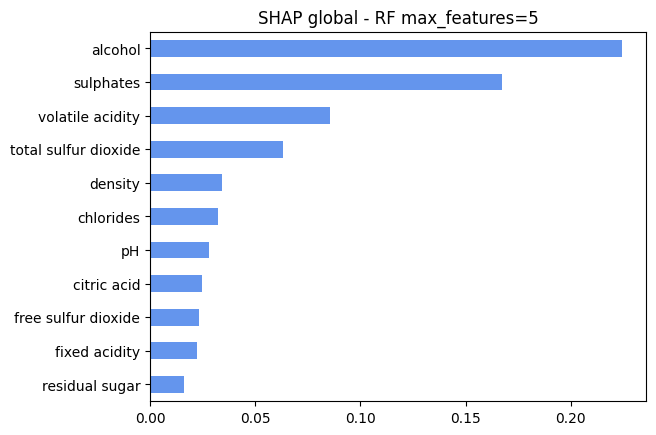

In [ ]:
# plot global importances
plot_importances(
    np.mean(np.abs(shap_values.values), axis=0),
    feature_names, title="SHAP global - RF max_features="+str(rf.max_features),
    order = True
)

# alternative plot from the shap package:
# shap.plots.bar(shap_values)

Compare with MDA and MDI plots.
> _It's very close to MDA on test sample (as expected)._

The main benefit of SHAP however is to provide local variable importances. Let us look at a given example:

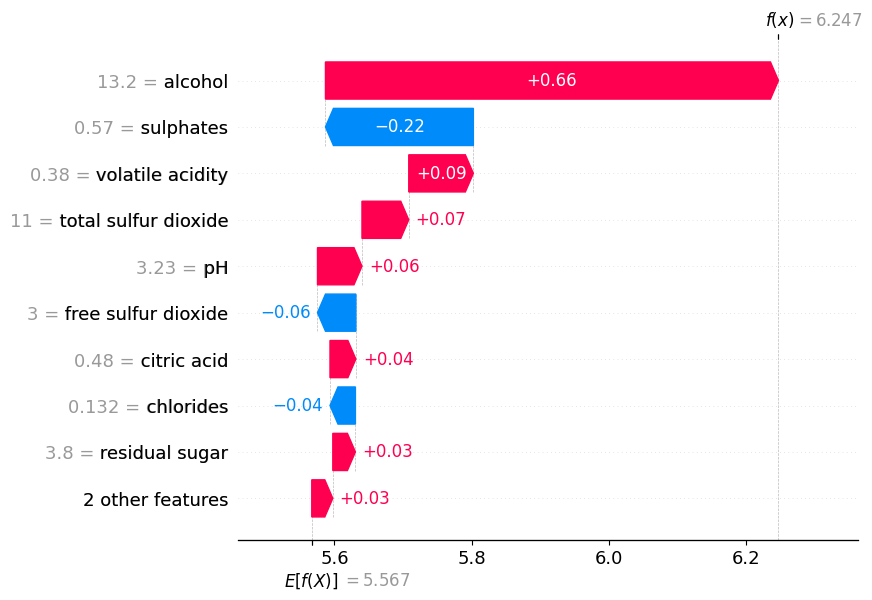

In [ ]:
shap.plots.waterfall(shap_values[34])
#myplot_waterfall(shap_values[0], order=True)

The sum of all values and the base value ($E[f(X)]$) is equal to the prediction of the model. Positive (resp. negative) value for a given variable indicates that the variable contributes to increase (resp. decrease) the value of the output.

*__Suggested experiment__*: _Change the instance index to see how these plots change from one instance to the next. For example, determine the highest/lowest predicted output on the test set (you can get all predictions with `rf.predict(X_test)`) and compare their plots._

Beeswarm plots are a way to look at the full test set at the same time:

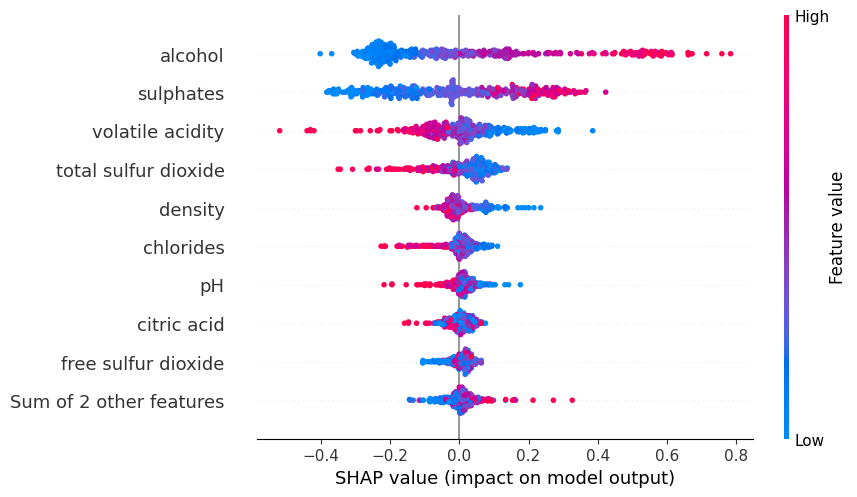

In [ ]:
shap.plots.beeswarm(shap_values)

Each point in this plot is an example from the test set. Points to the left (resp. right) of the 0.0 are such that the feature has a negative (resp. positive) effect on the output. Color represents the value of the feature. For example, 'alcohol' has mostly a negative effect on wine preference, when its value is low. This is the opposite for 'citric acid'.

A last kind of plot shows the evaluation of the impact of a feature with respect to its value:

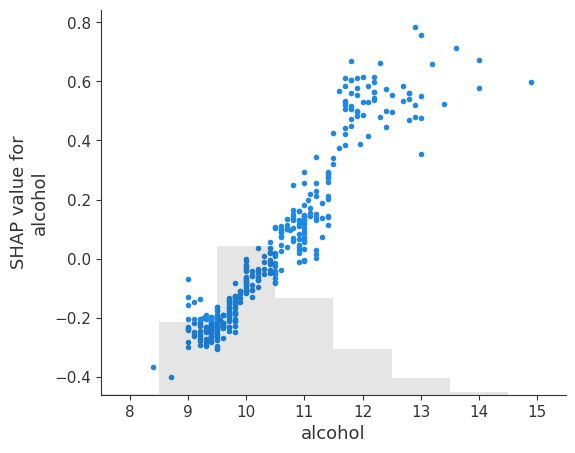

In [ ]:
shap.plots.scatter(shap_values[:,'alcohol'])

The plot here shows that alcohol has more positive impact on preference as it increases.

An alternative to such plot is partial dependence plots that show how the prediction of the model evolves, in average over all other feature values, with respect to give feature or pairs of features. Such plot can be obtained in scikit-learn with:

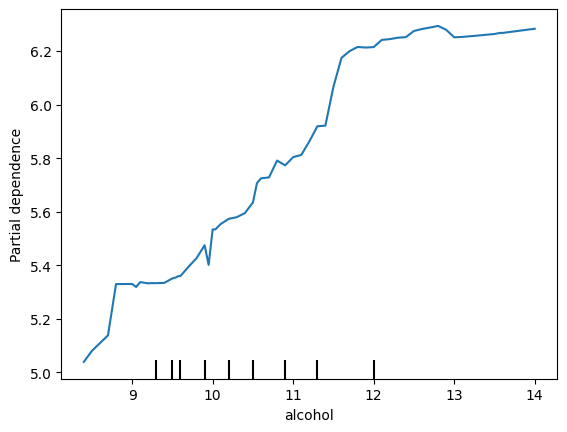

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(rf, X_train, ['alcohol'])

This latter plot confirms that wine preference increases with `alcohol`

# Variable selection

In this section, we test techniques to transform an importance ranking into a subset of variables.

## RFE

RFE is a technique to select a subset of variables so as to explicitely maximise accuracy. It can work with any variable importance measure but we will use it here of course with Random forests.

RFE is implemented in scikit-learn with two functions: `sklearn.feature_selection.RFE` and `sklearn.feature_selection.RFECV`. The first one assumes that you provide the number of variables that you want to select, while the second one uses cross-validation to automatically select a number of variables (i.e., the number of variables that lead to a maximum value of the score of the model, $R^2$ in regression, as estimated by cross-validation).

Let us first define the RFE model:

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

rf = RandomForestRegressor(max_features=5, random_state=RS)

rfecv = RFECV(estimator=rf, cv=KFold(5, shuffle=True, random_state=RS), step=1)

`step=1` means that we will iteratively remove one variable at a time until all variables are removed. In case there are many variables, this value should be increased to reduce computing times. If step is <1, it represents the proportion of variables removed at each iteration (a typical value is 0.5 that halves the number of variables at each iteration).

Let us run the RFE algorithm on the training data:

In [ ]:
# this can take some time
rfecv.fit(X_train,y_train)

RFECV(cv=KFold(n_splits=5, random_state=12345, shuffle=True),
      estimator=RandomForestRegressor(max_features=5, random_state=12345))

One can get the number of selected features using `rfecv.n_features_` and see the selected features with `feature_names[rfecv.support_]`.

In [ ]:
print("Number of selected features: ", rfecv.n_features_, " out of ", rfecv.n_features_in_)
print("Selected features: ",feature_names[rfecv.support_])
print("Removed features: ",feature_names[~rfecv.support_])

Number of selected features:  9  out of  11
Selected features:  ['fixed acidity' 'volatile acidity' 'citric acid' 'chlorides'
 'total sulfur dioxide' 'density' 'pH' 'sulphates' 'alcohol']
Removed features:  ['residual sugar' 'free sulfur dioxide']


One can also look at the evolution of the CV score with respect to the number of variables:

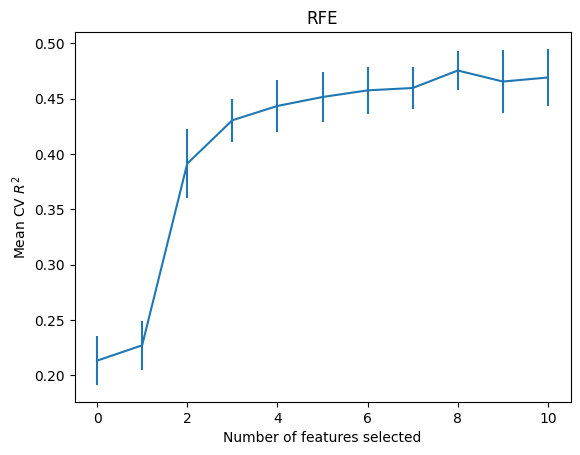

In [ ]:
plt.xlabel("Number of features selected")
plt.ylabel("Mean CV $R^2$")
plt.errorbar(
    range(X_train.shape[1]),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("RFE")
plt.show()

Only two features are removed, but it is clear that the performance starts decreasing significantly only when there remain about 4-5 features.

*__Suggested experiment__*: _change the value of max_features to 1 and rerun. Typically, using max_features=1 makes RF less robust to the introduction of irrelevant variables and this leads to a more conservative selection._

Once the procedure has been run, the `rfecv` python object is actually a rf estimator, trained on the selected features, that can be tested and used to make predictions as usual (with rfecv.predict() for example). Let us evaluate its performance:

In [ ]:
mse_train = mean_squared_error(y_train, rfecv.predict(X_train))
mse_test = mean_squared_error(y_test, rfecv.predict(X_test))
print("RF Training MSE: ", mse_train, "- Test MSE: ", mse_test)

RF Training MSE:  0.04689432860717264 - Test MSE:  0.331239


A faster way to run RFECV is to use OOB score estimates instead of 5-fold CV. This can be done with the following code:

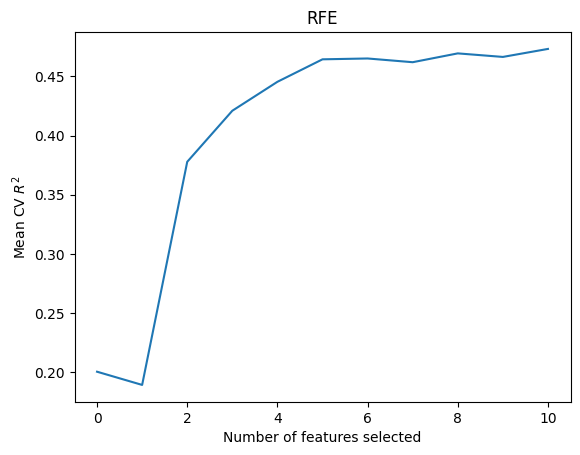

Number of selected features:  11  out of  11
Selected features:  ['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol']
Removed features:  []


In [ ]:
# Alternative using OOB score
from sklearn.feature_selection import RFECV

rf = RandomForestRegressor(max_features=5, oob_score=True, random_state=RS)
rfecv = RFECV(estimator=rf, step=1,
              # the following option forces the train-test split to put all samples in the train set
              cv=[(np.arange(X_train.shape[0]), np.empty(0, dtype=int))],
              # We use the oob score for selection
              scoring=lambda est, X, y: est.oob_score_)
rfecv.fit(X_train,y_train)
plt.xlabel("Number of features selected")
plt.ylabel("Mean CV $R^2$")
plt.errorbar(
    range(X_train.shape[1]),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("RFE")
plt.show()
print("Number of selected features: ", rfecv.n_features_, " out of ", rfecv.n_features_in_)
print("Selected features: ",feature_names[rfecv.support_])
print("Removed features: ",feature_names[~rfecv.support_])

No variable gets removed but again a plateau is reached already with 5 variables.

## All-relevant

RFE searches for the subset of features that maximises predictive performance. Let us consider instead the problem of determining which features are truly relevant at the top of the importance ranking. Most methods to do that carry out some permutation test to estimate the significance of the importance score.

The function mprobes (in ECAS.py) runs the following simple test (called mProbes in this [paper](https://academic.oup.com/bioinformatics/article/28/13/1766/234473?login=false)): it doubles the number of variables in the dataset by adding a randomly permuted copy of each original variable. Then, a RF model is trained on this new dataset to rank the variables. A score similar to a family-wise error rate is then obtained by counting among T repetitions of this procedure how many times each variable gets an importance score lower than a random copy of one of the variable and dividing this count by T.

Let us perform this test on our illustrative example with T=100 (it can take some time):

In [ ]:
import ECAS

rf = RandomForestRegressor(max_features=5, random_state=RS) # default parameters
FWER = ECAS.mprobes(X_train, y_train, rf, 100)

Compute the initial ranking...
Compute the permutation rankings...
....................................................................................................
elapsed time: 50.53 seconds



In [ ]:
FWER.sort_values(['FWER','Imp'], ascending=[True, False])

,Imp,FWER
alcohol,0.227416,0.00
sulphates,0.149454,0.00
volatile acidity,0.114975,0.00
total sulfur dioxide,0.078672,0.00
density,0.074848,0.00
chlorides,0.069701,0.00
pH,0.062091,0.00
fixed acidity,0.059394,0.00
citric acid,0.058764,0.00
residual sugar,0.053463,0.14


The FWER column can be interepreted as follows: if you accept that all variables above and including one variable in the ranking are relevant, it represents the risk that one purely irrelevant variable (i.e. a random copy) would get wrongly selected. If we accept a risk of 5% of being wrong, then we can select the first 9 variables as being relevant, but not the two last ones.

[`Boruta`](https://github.com/scikit-learn-contrib/boruta_py) is a more sophisticated algorithm based also on the idea of doubling the number of variables with randomly permuted copies of the original ones. It is typically less stringent than our simple test in that a variable is considered non significant only if its importance is significantly lower (according to a t-test) than the most important permuted variable. It thus potentially allows to select more variables.

Let us run it:

In [ ]:
from boruta_py import BorutaPy
rf = RandomForestRegressor(max_features=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(X_train, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	2
Rejected: 	0
Iteration:

BorutaPy(estimator=RandomForestRegressor(max_features=5, n_estimators=46,
                                         random_state=RandomState(MT19937) at 0x7A3FA9022D40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7A3FA9022D40, verbose=2)

In [ ]:
FWER['Boruta'] = feat_selector.ranking_
FWER.sort_values(['Boruta','Imp','FWER'], ascending=[True, False, False])

,Imp,FWER,Boruta
alcohol,0.227416,0.00,1
sulphates,0.149454,0.00,1
volatile acidity,0.114975,0.00,1
total sulfur dioxide,0.078672,0.00,1
density,0.074848,0.00,1
chlorides,0.069701,0.00,1
pH,0.062091,0.00,1
fixed acidity,0.059394,0.00,1
citric acid,0.058764,0.00,1
residual sugar,0.053463,0.14,2


The variable selected by Boruta are marked with a 1. In this example, the same variables are selected as with mprobes.

*__Suggested additional experiments__*:
* _redo the experiments but changing the RF parameters. In particular, try with max_features set to 11._
> When max_features is increased, less variables are typically selected as there is more competition between them during node splitting. You should observe than both mprobes and boruta pick up less variables.
* _introduce 10 random features and see how this affects RFE and Boruta. You can introduce random variables in the dataset using the code below._
> Typically adding irrelevant noisy variables should make finding the relevant ones a more difficult task. In practice, you will indeed observe that mProbes select fewer variables. Boruta on the other hand still manage to pick the same 8 variables as with the original data.

In [ ]:
X_train_noise = X_train.copy()
for i in range(10):
    X_train_noise['f'+str(i)] = np.random.normal(size=X_train.shape[0])
X_train_noise

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,...,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9
808,7.4,0.530,0.12,1.9,0.165,4.0,12.0,0.99702,3.26,0.86,...,-0.537485,1.457758,0.429319,-0.295966,0.010009,0.864616,0.587113,0.671900,-1.090926,0.952816
766,8.8,0.590,0.18,2.9,0.089,12.0,74.0,0.99738,3.14,0.54,...,-0.178892,1.299204,0.454764,1.203819,1.144308,-0.040728,-0.425204,1.100559,-0.501097,-0.374626
67,6.6,0.705,0.07,1.6,0.076,6.0,15.0,0.99620,3.44,0.58,...,0.616306,-0.743432,-0.293017,-1.015677,0.787820,-0.546375,0.919503,-1.164880,-2.394329,-1.386244
710,10.6,1.025,0.43,2.8,0.080,21.0,84.0,0.99850,3.06,0.57,...,-1.192088,-0.884298,-0.718872,-0.425244,-1.267603,-1.143115,-0.320480,-0.624045,1.827100,1.240624
1164,9.0,0.785,0.24,1.7,0.078,10.0,21.0,0.99692,3.29,0.67,...,-1.496894,-0.723560,-0.296026,-0.006791,-2.394224,0.218473,0.390372,1.255527,-1.038259,-1.762382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,7.3,0.670,0.02,2.2,0.072,31.0,92.0,0.99566,3.32,0.68,...,0.794633,-2.627010,-0.894734,-1.895092,0.391055,1.276370,-0.622423,-0.139937,1.556969,0.094571
129,6.1,0.380,0.15,1.8,0.072,6.0,19.0,0.99550,3.42,0.57,...,-1.896810,0.473168,0.480339,-0.656266,-0.475566,-0.054719,-1.123362,1.110649,0.038386,-1.462380
1309,7.0,0.620,0.10,1.4,0.071,27.0,63.0,0.99600,3.28,0.61,...,1.250493,-0.913617,-0.898492,0.579053,-0.584022,-1.753018,0.761142,-0.608643,0.330054,-0.235072
1509,7.9,0.180,0.40,1.8,0.062,7.0,20.0,0.99410,3.28,0.70,...,-0.771700,-0.296704,0.217651,1.289546,0.913808,-0.723425,0.364742,-0.420158,1.316666,-0.761242


__This is the end of this practical.__